Using device: cuda:0
Vocabulary size: 50257

======= Starting test for length: 50 tokens =======


=== Testing with KV cache (50 tokens) ===
Memory cleared
Model loaded successfully: ./model_checkpoints/kvcache_transformer_epoch_1.pt
Memory cleared
Running warm-up...
Memory cleared
Starting formal test...
Generated 50 tokens with KV cache in: 0.304 seconds
Memory cleared

=== Testing without KV cache (50 tokens) ===
Memory cleared
Model loaded successfully: ./model_checkpoints/kvcache_transformer_epoch_1.pt
Memory cleared
Running warm-up...
Memory cleared
Starting formal test...
Generated 50 tokens without KV cache in: 0.425 seconds
Memory cleared

Speedup for 50 tokens: 1.40x


======= Starting test for length: 100 tokens =======


=== Testing with KV cache (100 tokens) ===
Memory cleared
Model loaded successfully: ./model_checkpoints/kvcache_transformer_epoch_1.pt
Memory cleared
Running warm-up...
Memory cleared
Starting formal test...
Generated 100 tokens with KV cache in: 0.603 sec

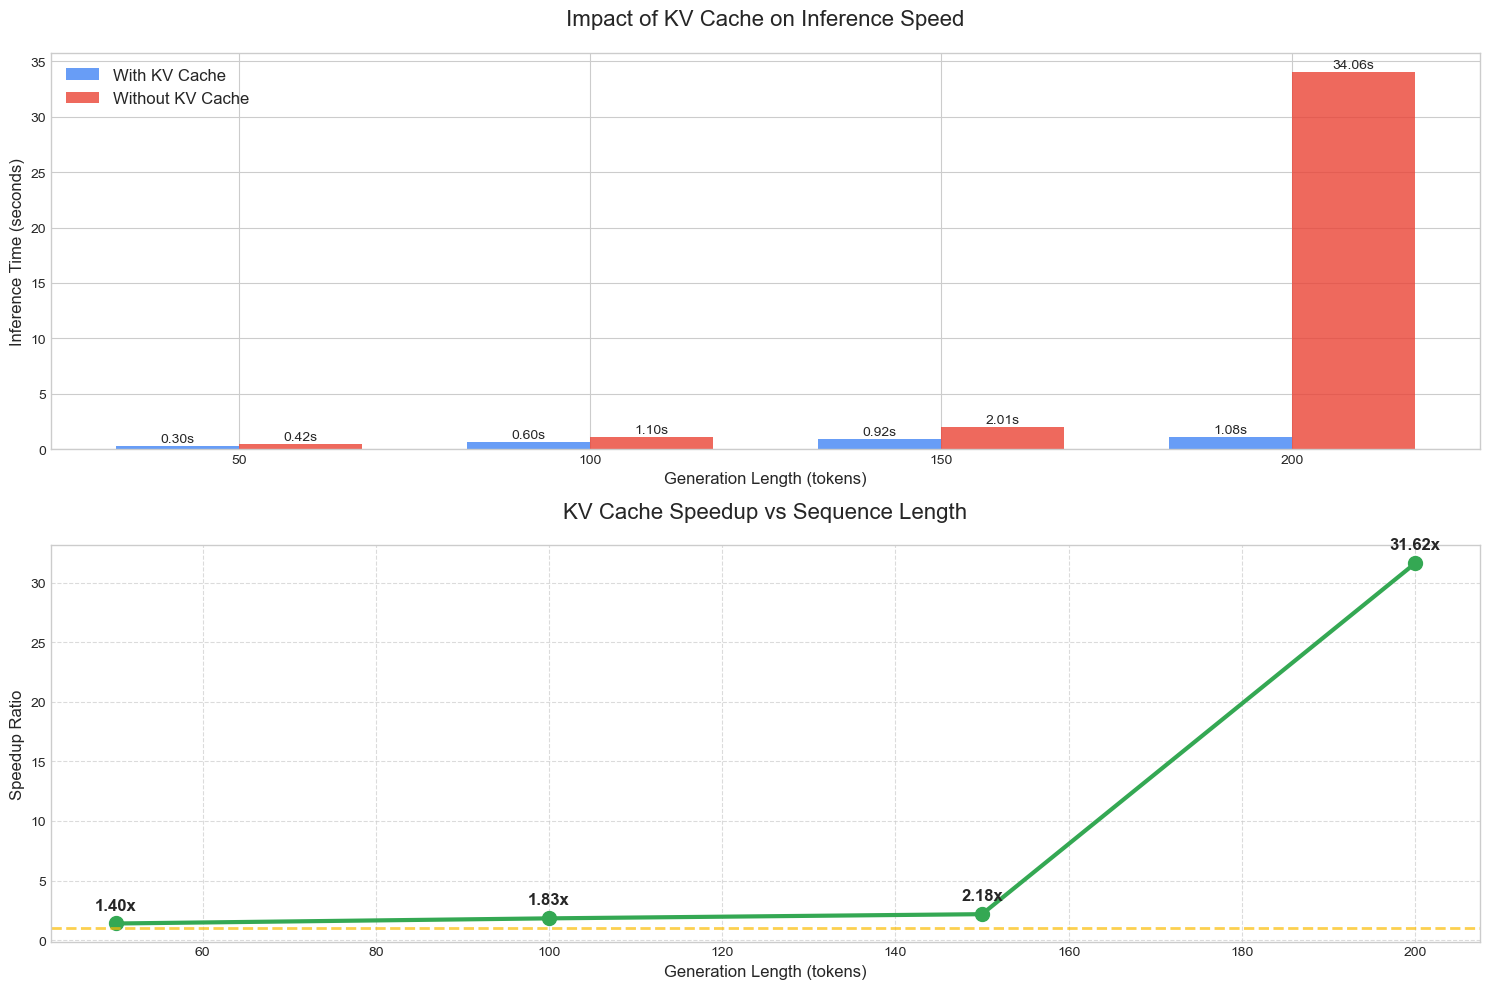


Results saved to kv_cache_benchmark_results.csv


In [1]:
# KV Cache Performance Test - Testing sequence lengths [50, 100, 150, 200]
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import gc
import psutil
import os
import sys
import tiktoken
from pathlib import Path

# Import model definitions
from script import TransformerModel, generate_text, generate_text_KV

# Configuration parameters
model_path = "./model_checkpoints/kvcache_transformer_epoch_1.pt"
prompt = "Once upon a time"
device_id = "cuda:0" if torch.cuda.is_available() else "cpu"
test_lengths = [50, 100, 150, 200]  # Test these lengths

# Set device
device = torch.device(device_id)
print(f"Using device: {device}")

# Load tokenizer
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab
print(f"Vocabulary size: {vocab_size}")

# Thoroughly clean memory
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    print("Memory cleared")

# Load model
def load_model():
    clear_memory()
    model = TransformerModel(vocab_size=vocab_size).to(device)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded successfully: {model_path}")
    except Exception as e:
        print(f"Failed to load model: {e}")
    return model

# Test single length with KV cache
def test_length_with_kv_cache(length):
    print(f"\n=== Testing with KV cache ({length} tokens) ===")
    model = load_model()
    model.eval()
    model.clear_cache()
    model.enable_cache()
    
    clear_memory()
    
    # Warm-up run - not counted in results
    print("Running warm-up...")
    with torch.no_grad():
        generate_text_KV(model, enc, prompt, max_new_tokens=min(50, length), device=device, top_p=0.95)
    model.clear_cache()
    clear_memory()
    
    # Formal test
    print("Starting formal test...")
    with torch.no_grad():
        start_time = time.time()
        generate_text_KV(model, enc, prompt, max_new_tokens=length, device=device, top_p=0.95)
        end_time = time.time()
        time_with_cache = end_time - start_time
    
    print(f"Generated {length} tokens with KV cache in: {time_with_cache:.3f} seconds")
    
    # Record memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    
    # Release model
    del model
    clear_memory()
    
    return time_with_cache, memory_usage

# Test single length without KV cache
def test_length_without_kv_cache(length):
    print(f"\n=== Testing without KV cache ({length} tokens) ===")
    model = load_model()
    model.eval()
    model.disable_cache()
    
    clear_memory()
    
    # Warm-up run - not counted in results
    print("Running warm-up...")
    with torch.no_grad():
        generate_text(model, enc, prompt, max_new_tokens=min(50, length), device=device, top_p=0.95)
    clear_memory()
    
    # Formal test
    print("Starting formal test...")
    with torch.no_grad():
        start_time = time.time()
        generate_text(model, enc, prompt, max_new_tokens=length, device=device, top_p=0.95)
        end_time = time.time()
        time_without_cache = end_time - start_time
    
    print(f"Generated {length} tokens without KV cache in: {time_without_cache:.3f} seconds")
    
    # Record memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    
    # Release model
    del model
    clear_memory()
    
    return time_without_cache, memory_usage

# Plot performance comparison charts
def plot_performance_comparison(lengths, times_with_cache, times_without_cache):
    # Calculate speedups
    speedups = [no_cache/with_cache for with_cache, no_cache in zip(times_with_cache, times_without_cache)]
    
    # Set a nicer style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    plt.figure(figsize=(15, 10))
    
    # Chart 1: Inference time comparison
    plt.subplot(2, 1, 1)
    
    x = np.arange(len(lengths))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, times_with_cache, width, label='With KV Cache', color='#4285F4', alpha=0.8)
    bars2 = plt.bar(x + width/2, times_without_cache, width, label='Without KV Cache', color='#EA4335', alpha=0.8)
    
    plt.xlabel('Generation Length (tokens)', fontsize=12)
    plt.ylabel('Inference Time (seconds)', fontsize=12)
    plt.title('Impact of KV Cache on Inference Speed', fontsize=16, pad=20)
    plt.xticks(x, lengths)
    plt.legend(fontsize=12)
    
    # Add data labels
    for i, v in enumerate(times_with_cache):
        plt.text(i - width/2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom', fontsize=10)
    
    for i, v in enumerate(times_without_cache):
        plt.text(i + width/2, v + 0.1, f"{v:.2f}s", ha='center', va='bottom', fontsize=10)
    
    # Chart 2: Speedup ratio
    plt.subplot(2, 1, 2)
    
    plt.plot(lengths, speedups, 'o-', color='#34A853', linewidth=3, markersize=10)
    plt.axhline(y=1.0, color='#FBBC05', linestyle='--', alpha=0.7, linewidth=2)
    
    plt.xlabel('Generation Length (tokens)', fontsize=12)
    plt.ylabel('Speedup Ratio', fontsize=12)
    plt.title('KV Cache Speedup vs Sequence Length', fontsize=16, pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add speedup labels
    for i, (length, speedup) in enumerate(zip(lengths, speedups)):
        plt.annotate(f"{speedup:.2f}x", 
                    xy=(length, speedup),
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center',
                    fontsize=12,
                    weight='bold')
    
    plt.tight_layout()
    plt.savefig('kv_cache_performance.png', dpi=300)
    plt.show()

# Main function - test all lengths
def run_complete_benchmark():
    # Store results
    times_with_cache = []
    times_without_cache = []
    memory_with_cache = []
    memory_without_cache = []
    
    # Test each length
    for length in test_lengths:
        print(f"\n======= Starting test for length: {length} tokens =======\n")
        
        # Test with KV cache
        time_with, mem_with = test_length_with_kv_cache(length)
        times_with_cache.append(time_with)
        memory_with_cache.append(mem_with)
        
        # Test without KV cache
        time_without, mem_without = test_length_without_kv_cache(length)
        times_without_cache.append(time_without)
        memory_without_cache.append(mem_without)
        
        # Calculate and print speedup for current length
        speedup = time_without / time_with
        print(f"\nSpeedup for {length} tokens: {speedup:.2f}x\n")
        print("=" * 50)
    
    # Print final results table
    print("\nFinal Results Summary:")
    print("-" * 90)
    print(f"{'Length':<10}{'Time (w/ cache)':<18}{'Time (w/o cache)':<18}{'Speedup':<10}{'Memory (w/ cache)':<18}{'Memory (w/o cache)':<18}")
    print("-" * 90)
    
    speedups = [no_cache/with_cache for with_cache, no_cache in zip(times_with_cache, times_without_cache)]
    for i, length in enumerate(test_lengths):
        print(f"{length:<10}{times_with_cache[i]:<18.3f}{times_without_cache[i]:<18.3f}{speedups[i]:<10.2f}{memory_with_cache[i]:<18.1f}{memory_without_cache[i]:<18.1f}")
    
    # Plot performance comparison charts
    plot_performance_comparison(test_lengths, times_with_cache, times_without_cache)
    
    # Save data to CSV file
    import pandas as pd
    results = pd.DataFrame({
        'Length': test_lengths,
        'Time (w/ cache)': times_with_cache,
        'Time (w/o cache)': times_without_cache,
        'Speedup': speedups,
        'Memory (w/ cache)': memory_with_cache,
        'Memory (w/o cache)': memory_without_cache
    })
    results.to_csv('kv_cache_benchmark_results.csv', index=False)
    print("\nResults saved to kv_cache_benchmark_results.csv")
    
    return results

# Run complete benchmark
if __name__ == "__main__":
    run_complete_benchmark()